In [2]:
%matplotlib inline

In [3]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML
import ipywidgets as wg
from ipywidgets import HBox, VBox, Label, IntSlider

In [4]:
animation.embed_limit = 32

In [5]:
def generateCities(N,Width):
    cities = list(range(0,N))
    citiesCords=list(zip(list(np.array(random.random(N))*Width),list(np.array(random.random(N))*Width)))
    return cities,citiesCords

In [6]:
def euclideanMetric(pair,citiesCords):
    city1,city2=pair
    x1,y1=citiesCords[city1]
    x2,y2=citiesCords[city2]
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

In [7]:
def manhattanMetric(pair,citiesCords):
    city1,city2=pair
    x1,y1=citiesCords[city1]
    x2,y2=citiesCords[city2]
    return abs(x2-x1)+abs(y2-y1)

In [8]:
def totalDist(cities,citiesCords,metric):
    pairs = list(zip(cities[::],cities[1:]+cities[:1]))
    return sum(map(lambda pair: metric(pair,citiesCords),pairs))

In [9]:
def rotate(l, n):
    return l[-n:] + l[:-n]

In [10]:
def randomSwap(cities,citiesCords,metric,radius):
    cities = rotate(cities,random.randint(0,len(cities)))
    idx1 = 0
    idx2 = random.choice([idx for idx in range(2,len(cities)-1) if metric((cities[idx1],cities[idx]),citiesCords)<radius])
    cities[idx1:idx2] = cities[idx1:idx2][::-1]
    return cities

In [11]:
boltzman = 1.380650424242424*10.0**(-23.0)

In [12]:
def metropolis(cities,citiesCords,temp,metric,radius,phi):
    newCities = cities.copy()
    newCities = randomSwap(newCities,citiesCords,metric,radius)
    
    newDist = totalDist(newCities,citiesCords,metric)
    oldDist = totalDist(cities,citiesCords,metric)
    diff = newDist - oldDist
    R = random.random()
    if(diff>0):
        #print(R,(-diff*phi)/(boltzman*newDist),np.exp((-diff*phi)/(boltzman*newDist)))
        if(np.exp((-diff*phi)/(boltzman*temp))<=R):
            return cities
    return newCities       

In [13]:
def simulatedAnnealing(cities,citiesCords,metric,start_temp,end_temp,radius,phi):
    configurations = [cities]
    dist = [totalDist(cities,citiesCords,metric)]
    temp = start_temp
    l = 10
    diff = 0.1
    while temp>end_temp:
        oldDist = 0
        newDist = totalDist(cities,citiesCords,metric)
        while abs(newDist - oldDist)>diff:
            oldDist = newDist
            for _ in range(1,l):
                cities = metropolis(cities,citiesCords,temp,metric,radius,phi)
                configurations.append(cities)
                dist.append(totalDist(cities,citiesCords,metric))
            newDist = totalDist(cities,citiesCords,metric)
        temp=0.95*temp;
    return dist,configurations

In [14]:
def simulation(citiesNumber,metric,temps,visualization):
    
    phi=10.0**(-21)
    end_temp,start_temp=temps
    width = citiesNumber/2
    radius = 10*citiesNumber
    cities,citiesCords=generateCities(citiesNumber,width)
    distances,configuration = simulatedAnnealing(cities,citiesCords,metric,start_temp,end_temp,radius,phi)
    

    fig, ax = plt.subplots()
    ax.set_xlim(( 0, width))
    ax.set_ylim((0, width))
    line, = ax.plot([], [],'r-')
    
    frames_number = int(visualization*len(configuration))
    frame_gap = len(configuration)//frames_number

    def init():
        cords = list(zip(*(map(lambda city: citiesCords[city],cities+cities[:1]))))
        line.set_data(cords[0],cords[1])
        return (line,)

    def animate(i):
        
        i=i*frame_gap
        if i>=len(configuration):
            i=len(configuration)-1         
        cords = list(zip(*(map(lambda city: citiesCords[city],configuration[i]+configuration[i][:1]))))
        x = cords[0]
        y = cords[1]
        line.set_data(x, y)
        return (line,) 

    plt.close()

    anim = animation.FuncAnimation(fig, animate, init_func=init,frames=frames_number+1, interval=100, blit=True)
    return anim,distances
    #plt.cla()
    #plt.clf()

    #print(distances)
    #plt.plot(distances)
    

In [15]:
def run():
    cities_slide = wg.IntSlider(
        value=10,
        min=4,
        max=100,
        step=1)

    temperatures_slide = wg.FloatRangeSlider(
        value=[1,100],
        min=0.1,
        max=1000.0,
        step=0.1,
        readout_format='.1f',
    )
    metricButtons = wg.RadioButtons(
        options=['Euclidean', 'Manhattan'],
        value='Euclidean',
    )
    
    animation_slide = wg.IntSlider(
        value=10,
        min=1,
        max=100,
        step=1)
    
    descriptions = [Label(x) for x in ['Cities:', 'Temperatures:','Animation %','Metric']]
    items = [cities_slide,temperatures_slide,animation_slide,metricButtons]

    left_box = VBox(descriptions)
    right_box = VBox(items)
    ala = display(HBox([left_box, right_box]))

    def on_button_clicked(b):
        
        for item in items:
            item.close()     
        for description in descriptions:
            description.close() 
        button.close()     
        
        if metricButtons.value=='Euclidean' :
            metric = euclideanMetric
        else:
            metric = manhattanMetric
            
        anim,distances = simulation(cities_slide.value,metric,temperatures_slide.value,animation_slide.value/100)
        plt.plot(distances)
        display(HTML(anim.to_jshtml()))        

    button = wg.Button(description="Simulate")
    button.on_click(on_button_clicked)
    display(button)

Button(description='Simulate', style=ButtonStyle())

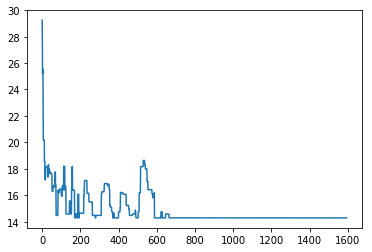

In [17]:
run()